In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import plot_model


In [2]:
img = np.load("/kaggle/input/tell-the-time/images.npy")
lbl = np.load('/kaggle/input/tell-the-time/labels.npy')


In [3]:
img = img.astype(float) / 255
img = np.expand_dims(img, -1)
input_shape = (150, 150, 1)

In [4]:
x_train, x_test, lbl_train, lbl_test = train_test_split(img, lbl, train_size=0.8, random_state=23)

x_train, x_val, lbl_train, lbl_val = train_test_split(x_train, lbl_train, test_size=0.125, random_state=23) # 0.125 * 0.8 = 0.1 

In [5]:
a = np.sin(5)
print(a)
b = np.cos(5)
print(b)
print(np.arctan2(a,b))

-0.9589242746631385
0.28366218546322625
-1.2831853071795865


In [6]:

hours_rad_train = 2 * np.pi * lbl_train[:,0] / 12
hours_sin_train = np.cos(hours_rad_train)
hours_cos_sign_train = np.array([0 if x < 0 else 1 for x in np.cos(hours_rad_train)])

minutes_rad_train = 2 * np.pi * lbl_train[:,1] / 60
minutes_sin_train = np.cos(minutes_rad_train)
minutes_cos_sign_train = np.array([0 if x < 0 else 1 for x in np.cos(minutes_rad_train)])

print(hours_rad_train[:10])
print(hours_sin_train[:10])
print(hours_cos_sign_train[:10])

print(minutes_rad_train[:10])
print(minutes_sin_train[:10])
print(minutes_cos_sign_train[:10])

print(lbl_train[:10])


[4.71238898 4.1887902  0.         1.04719755 5.23598776 3.14159265
 0.52359878 5.75958653 1.04719755 0.        ]
[-1.83697020e-16 -5.00000000e-01  1.00000000e+00  5.00000000e-01
  5.00000000e-01 -1.00000000e+00  8.66025404e-01  8.66025404e-01
  5.00000000e-01  1.00000000e+00]
[0 0 1 1 1 0 1 1 1 1]
[1.36135682 0.83775804 0.         1.57079633 4.92182849 1.57079633
 3.97935069 0.         5.44542727 2.19911486]
[ 2.07911691e-01  6.69130606e-01  1.00000000e+00  2.83276945e-16
  2.07911691e-01  2.83276945e-16 -6.69130606e-01  1.00000000e+00
  6.69130606e-01 -5.87785252e-01]
[1 1 1 1 1 1 0 1 1 0]
[[ 9 13]
 [ 8  8]
 [ 0  0]
 [ 2 15]
 [10 47]
 [ 6 15]
 [ 1 38]
 [11  0]
 [ 2 52]
 [ 0 21]]


In [7]:

hours_rad_val = 2 * np.pi * lbl_val[:,0] / 12
hours_sin_val = np.cos(hours_rad_val)
hours_cos_sign_val = np.array([0 if x < 0 else 1 for x in np.cos(hours_rad_val)])

minutes_rad_val = 2 * np.pi * lbl_val[:,1] / 60
minutes_sin_val = np.cos(minutes_rad_val)
minutes_cos_sign_val = np.array([0 if x < 0 else 1 for x in np.cos(minutes_rad_val)])


In [8]:
hours_rad_test = 2 * np.pi * lbl_test[:,0] / 12
hours_sin_test  = np.cos(hours_rad_test )
hours_cos_sign_test  = np.array([0 if x < 0 else 1 for x in np.cos(hours_rad_test )])

minutes_rad_test  = 2 * np.pi * lbl_test[:,1] / 60
minutes_sin_test  = np.cos(minutes_rad_test )
minutes_cos_sign_test  = np.array([0 if x < 0 else 1 for x in np.cos(minutes_rad_test )])


In [9]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, clock_val, lbl_val, custom_metric):
        self.clock_val = clock_val
        self.lbl_val = lbl_val
        self.custom_metric = custom_metric
        self.errors = []
        
    def on_epoch_end(self, epoch, logs=None):
        hours_cos_out, hours_half_out, minutes_cos_out, minutes_half_out = self.model.predict(self.clock_val,batch_size = 16)
        
        error = custom_metric(hours_cos_out, hours_half_out, minutes_cos_out, minutes_half_out, self.lbl_val)
        
        self.errors.append(error)
        hours = np.int16(error/60)
        minutes = error - 60 * hours
        print(f"Error = hours:{hours}  minutes:{minutes}") 
        

    

2022-11-25 20:12:51.903841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 20:12:51.992733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 20:12:51.993550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 20:12:51.994851: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

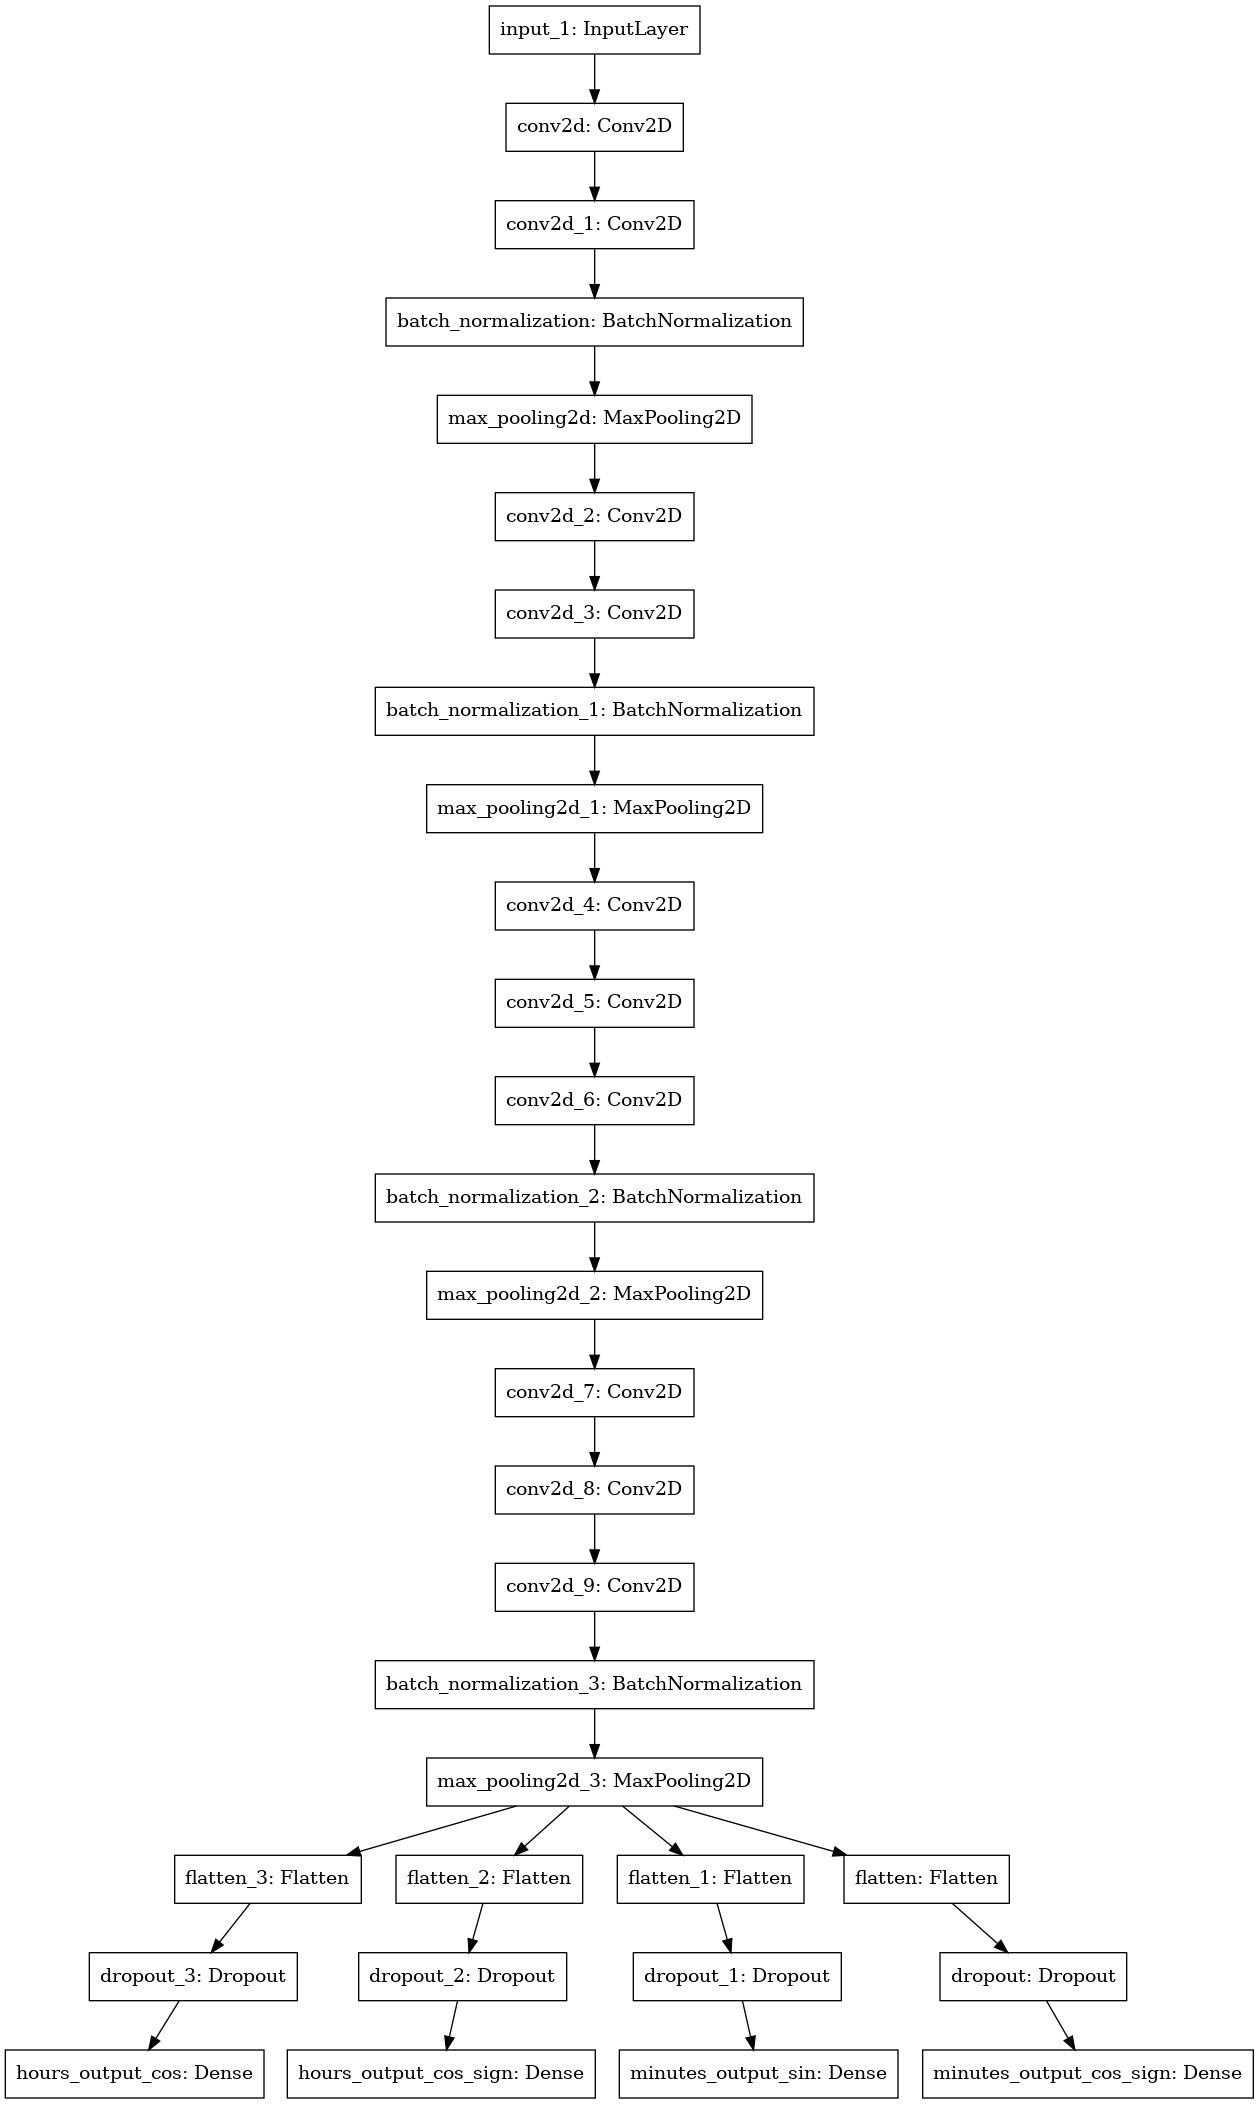

In [10]:
def create_convblock(filters, n, layer):
    for _ in range(n):
        layer = keras.layers.Conv2D(filters, kernel_size=(3, 3), activation='gelu',padding='same')(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    return layer

def create_model():
    input_layer = keras.layers.Input(shape=(input_shape))
    layer = create_convblock(32,2,input_layer)
    max_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(layer)
    layer = create_convblock(64,2,max_layer)
    max_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(layer)
    layer = create_convblock(128,3,max_layer)
    max_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(layer)
    layer = create_convblock(256,3,max_layer)
    split_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(layer)
    
    minutes_output_cos_sign = keras.layers.Flatten()(split_layer)
    minutes_output_cos_sign = keras.layers.Dropout(0.1)(minutes_output_cos_sign)
    minutes_output_cos_sign =  keras.layers.Dense(1, activation='sigmoid',name="minutes_output_cos_sign")(minutes_output_cos_sign)
    
    minutes_output_sin = keras.layers.Flatten()(split_layer)
    minutes_output_sin = keras.layers.Dropout(0.1)(minutes_output_sin)
    minutes_output_sin =  keras.layers.Dense(1, activation='tanh',name="minutes_output_sin")(minutes_output_sin)
    
    hours_output_cos_sign = keras.layers.Flatten()(split_layer)
    hours_output_cos_sign =  keras.layers.Dropout(0.1)(hours_output_cos_sign)
    hours_output_cos_sign =  keras.layers.Dense(1, activation='sigmoid', name="hours_output_cos_sign")(hours_output_cos_sign)
    
    hours_output_sin = keras.layers.Flatten()(split_layer)
    hours_output_sin =  keras.layers.Dropout(0.1)(hours_output_sin)
    hours_output_sin =  keras.layers.Dense(1, activation='tanh', name="hours_output_cos")(hours_output_sin)
    
    
    return  keras.Model(inputs=[input_layer],outputs=[hours_output_sin,hours_output_cos_sign,minutes_output_sin,minutes_output_cos_sign])

model = create_model()
plot_model(model)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 150, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 150, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
# # compile models
model.compile(loss= ['mse','binary_crossentropy','mse','binary_crossentropy'],
            optimizer="Adam",
            loss_weights =[3,2,1,1]
            )

In [21]:
def custom_metric(hours_sin_out, hours_cos_sign_out, minutes_sin_out, minutes_cos_sign_out, lbl):
    hours_sin_out = np.squeeze(hours_sin_out)
    hours_cos_out = np.sqrt(1 - hours_sin_out**2) * np.array([-1 if x<0.5 else 1 for x in hours_cos_sign_out])
    
    hour_out = np.array([np.int16(x+0.5) if x > 0 else np.int16(12.5+x)  for x in np.arctan2(hours_sin_out,hours_cos_out)/(2 * np.pi / 12)])
    print(np.unique(hour_out))
    
    minutes_sin_out = np.squeeze(minutes_sin_out)
    minutes_cos_out = np.sqrt(1 - minutes_sin_out**2) * np.array([-1 if x<0.5 else 1 for x in minutes_cos_sign_out])

    minute_out = np.array([x if x > 0 else 60+x  for x in np.arctan2(minutes_sin_out,minutes_cos_out)/(2 * np.pi / 60)])
    

    
    error_hour = np.abs(lbl[:,0] - hour_out)
    
    error_hour = np.array([x if x <= 6 else 12 - x for x in error_hour]) * 60
    
    error_minute = np.abs(lbl[:,1] - minute_out)
    
    error_minute = np.array([x if x <= 30 else 60 - x for x in error_minute])
    
    error = error_hour + error_minute
    
   
    
    return np.mean(error)



In [15]:
callback = CustomCallback(x_val, lbl_val, custom_metric)
history = model.fit(x_train, [hours_sin_train,hours_cos_sign_train,minutes_sin_train,minutes_cos_sign_train], 
                    epochs = 100,
                    batch_size = 128,
                    callbacks = [callback]
                    )

2022-11-25 20:14:28.706299: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1134000000 exceeds 10% of free system memory.
2022-11-25 20:14:30.157232: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1134000000 exceeds 10% of free system memory.
2022-11-25 20:14:31.102748: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-11-25 20:14:34.313347: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


99/99 [==============================] - 38s 285ms/step - loss: 8.8551 - hours_output_cos_loss: 1.4568 - hours_output_cos_sign_loss: 1.0076 - minutes_output_sin_loss: 1.5006 - minutes_output_cos_sign_loss: 0.9689
Error = hours:3  minutes:18.68930248725468
Epoch 2/100
99/99 [==============================] - 28s 279ms/step - loss: 7.8873 - hours_output_cos_loss: 1.3931 - hours_output_cos_sign_loss: 0.7456 - minutes_output_sin_loss: 1.4526 - minutes_output_cos_sign_loss: 0.7641
Error = hours:3  minutes:17.76745816313371
Epoch 3/100
99/99 [==============================] - 28s 279ms/step - loss: 8.0204 - hours_output_cos_loss: 1.4652 - hours_output_cos_sign_loss: 0.7342 - minutes_output_sin_loss: 1.3083 - minutes_output_cos_sign_loss: 0.8480
Error = hours:3  minutes:17.772777777777776
Epoch 4/100
99/99 [==============================] - 28s 279ms/step - loss: 7.2464 - hours_output_cos_loss: 1.3927 - hours_output_cos_sign_loss: 0.5599 - minutes_output_sin_loss: 1.3104 - minutes_output_cos_

KeyboardInterrupt: 

In [ ]:
errors = np.array(callback.errors)
np.save("history.npy", history.history)
np.save("errors.npy", errors)
model.save_weights("weights")

In [22]:
# model.load_weights()
hours_sin_out, hours_cos_sign_out, minutes_sin_out, minutes_cos_sign_out = model.predict(x_test)

error = custom_metric(hours_sin_out, hours_cos_sign_out, minutes_sin_out, minutes_cos_sign_out, lbl_test)
print(error)
hours = np.int16(error/60)
minutes = error - 60 * hours
print(f"Error = hours:{hours}  minutes:{minutes}")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
173.5977958483066
Error = hours:2  minutes:53.59779584830659
